/Users/achyutaryan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  1 of 1 completed
            Stock Price           Regime
Date                                    
2020-01-02    72.876106   Low Volatility
2020-01-03    72.167618   Low Volatility
2020-01-06    72.742668   Low Volatility
2020-01-07    72.400558  High Volatility
2020-01-08    73.565201  High Volatility


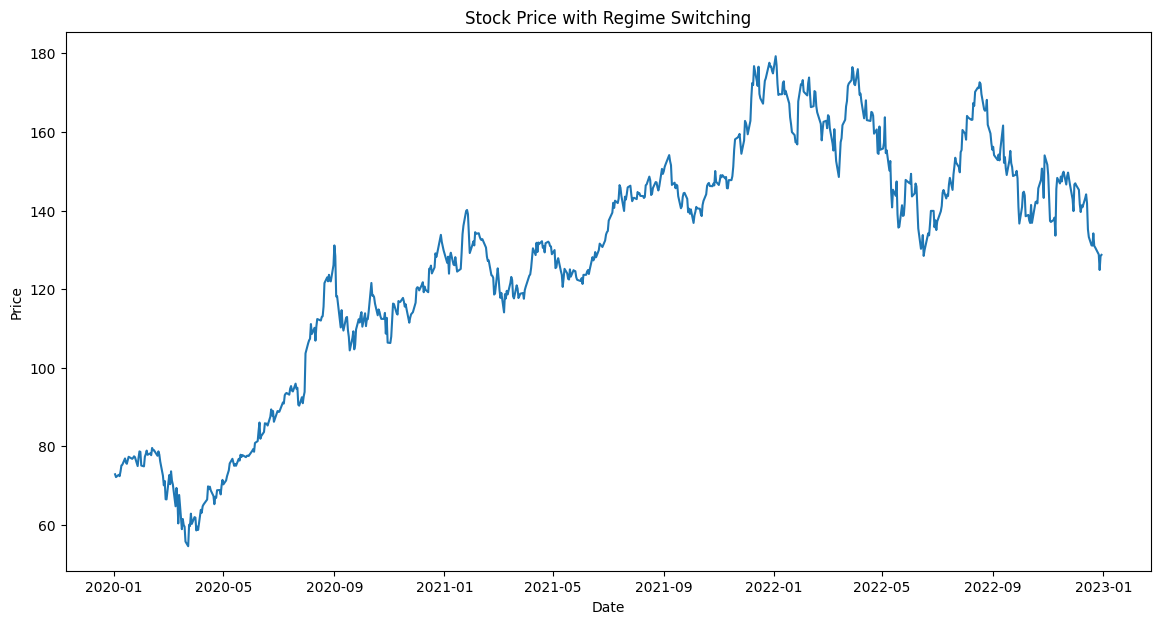

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetch historical stock price data from Yahoo Finance
def fetch_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)
    return stock_data['Adj Close']

# Fetch risk-free rate (e.g., 10-year US Treasury yield)
def fetch_risk_free_rate():
    # You can fetch this from FRED (Federal Reserve Economic Data)
    # Use 'yahoo' for simplified access or web scraping
    treasury_yield = yf.download('^TNX', start='2020-01-01', end='2023-01-01')['Adj Close']
    return treasury_yield / 100  # Convert to decimal

# Simulate regime switching using a semi-Markov process
def simulate_regime_switching(num_days):
    regimes = ['Low Volatility', 'High Volatility']
    # Transition probabilities (for simplicity, using a 2-state Markov chain)
    transition_matrix = np.array([[0.95, 0.05], [0.10, 0.90]])  # Example transition matrix
    regime_sequence = []
    current_state = 0  # Start in state 0 (Low Volatility)

    for _ in range(num_days):
        regime_sequence.append(regimes[current_state])
        current_state = np.random.choice([0, 1], p=transition_matrix[current_state])

    return regime_sequence

# Simulate market data based on stock prices and regime
def simulate_market_data(stock_data, regime_sequence):
    market_data = pd.DataFrame(index=stock_data.index)
    market_data['Stock Price'] = stock_data
    market_data['Regime'] = regime_sequence
    return market_data

# Example Usage
if __name__ == "__main__":
    # Define parameters
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']  # List of stocks
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data and risk-free rate
    stock_data = fetch_stock_data(tickers, start_date, end_date)
    risk_free_rate = fetch_risk_free_rate()

    # Simulate regime switching for the same period
    regime_sequence = simulate_regime_switching(len(stock_data))

    # Combine data into a market dataset
    market_data = simulate_market_data(stock_data['AAPL'], regime_sequence)  # Using Apple as an example

    # Display the market data
    print(market_data.head())

    # Plot stock price and regime over time
    plt.figure(figsize=(14, 7))
    plt.plot(market_data['Stock Price'], label='AAPL Stock Price')
    plt.title('Stock Price with Regime Switching')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()


1. Imports and Helper Functions


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch stock prices and risk-free rates (like before)
def fetch_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)
    return stock_data['Adj Close']

def fetch_risk_free_rate():
    treasury_yield = yf.download('^TNX', start='2020-01-01', end='2023-01-01')['Adj Close']
    return treasury_yield / 100  # Convert to decimal

# Simulate regime switching using a semi-Markov process
def simulate_regime_switching(num_days):
    regimes = ['Low Volatility', 'High Volatility']
    transition_matrix = np.array([[0.95, 0.05], [0.10, 0.90]])
    regime_sequence = []
    current_state = 0  # Start in Low Volatility
    for _ in range(num_days):
        regime_sequence.append(regimes[current_state])
        current_state = np.random.choice([0, 1], p=transition_matrix[current_state])
    return regime_sequence

# Simulate jump diffusion with Poisson jumps
def simulate_jump_diffusion(stock_data, lambda_jumps, mu_jump, sigma_jump):
    n = len(stock_data)
    jump_component = np.random.poisson(lambda_jumps, n) * np.random.normal(mu_jump, sigma_jump, n)
    return jump_component

# Combine everything into market data
def simulate_market_data(stock_data, regime_sequence, lambda_jumps, mu_jump, sigma_jump):
    market_data = pd.DataFrame(index=stock_data.index)
    market_data['Stock Price'] = stock_data
    market_data['Regime'] = regime_sequence

    # Simulate jumps in stock prices
    jumps = simulate_jump_diffusion(stock_data, lambda_jumps, mu_jump, sigma_jump)
    market_data['Stock Price with Jumps'] = market_data['Stock Price'] + jumps
    return market_data


2. Portfolio Optimization Framework


[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/g9/7fcnkw495y31h8wk89bx_5xm0000gn/T/ipykernel_59187/2496224289.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  u_opt[t] = (1 / theta) * (V[t] * (next_price - r_t) / (sigma_t ** 2))


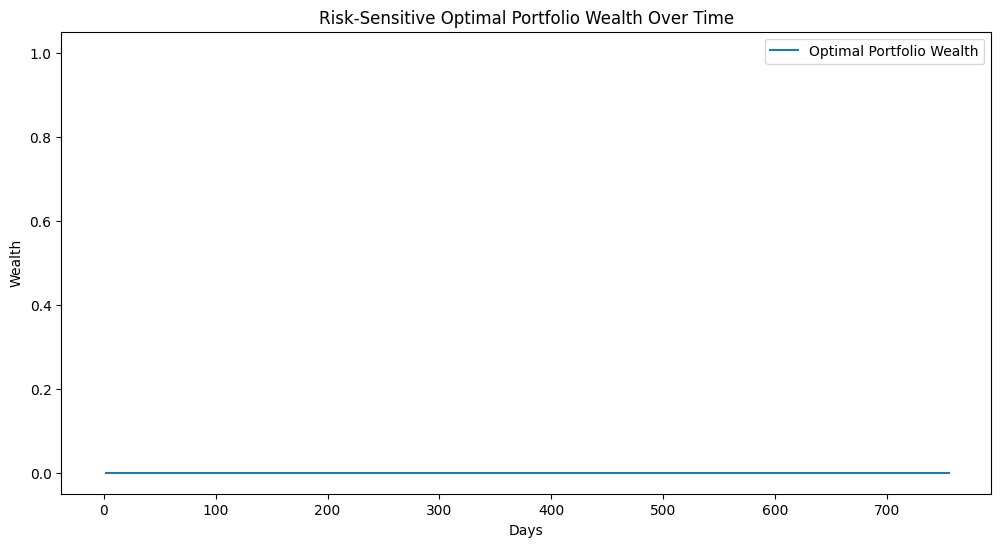

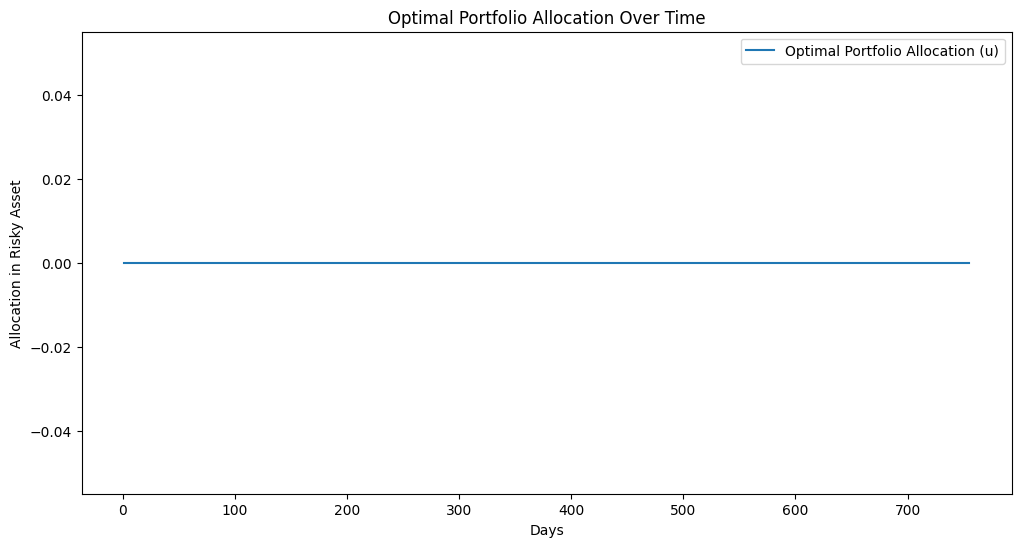

In [3]:
# Define utility and HJB equation for risk-sensitive optimization
def utility_function(V, theta):
    return -(2 / theta) * np.log(V)

# Hamilton-Jacobi-Bellman (HJB) solution approximation using finite difference
def hjb_optimization(market_data, theta, T):
    # Initialize parameters for the HJB solution
    num_steps = len(market_data)
    V = np.zeros(num_steps)  # Portfolio wealth
    u_opt = np.zeros(num_steps)  # Optimal portfolio allocation

    # Initial wealth
    V[0] = 1.0  # Assume $1 initial wealth
    dt = 1  # Time step in days

    # Risk-sensitive HJB equation solution (backward in time)
    for t in range(num_steps - 2, -1, -1):
        current_price = market_data['Stock Price with Jumps'].iloc[t]
        next_price = market_data['Stock Price with Jumps'].iloc[t + 1]
        r_t = 0.01  # Example risk-free rate, can be fetched

        # Estimate the optimal control u (proportion in risky asset)
        dV = (next_price - current_price) / current_price
        sigma_t = np.std(market_data['Stock Price with Jumps'][:t+1])

        # HJB optimal control based on the risk-sensitive objective
        u_opt[t] = (1 / theta) * (V[t] * (next_price - r_t) / (sigma_t ** 2))

        # Update the wealth based on optimal control
        V[t + 1] = V[t] * (1 + u_opt[t] * dV + r_t * dt)

    return V, u_opt

# Example usage:
if __name__ == "__main__":
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data and risk-free rate
    stock_data = fetch_stock_data(tickers, start_date, end_date)
    risk_free_rate = fetch_risk_free_rate()

    # Simulate regime switching
    regime_sequence = simulate_regime_switching(len(stock_data))

    # Simulate jump diffusion for AAPL
    lambda_jumps = 0.1  # Average number of jumps per day
    mu_jump = 0.01  # Average jump size
    sigma_jump = 0.02  # Jump volatility
    market_data = simulate_market_data(stock_data['AAPL'], regime_sequence, lambda_jumps, mu_jump, sigma_jump)

    # Apply risk-sensitive HJB optimization
    theta = 0.5  # Risk-aversion parameter
    T = len(market_data)  # Time horizon
    V_opt, u_opt = hjb_optimization(market_data, theta, T)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(V_opt, label='Optimal Portfolio Wealth')
    plt.title('Risk-Sensitive Optimal Portfolio Wealth Over Time')
    plt.xlabel('Days')
    plt.ylabel('Wealth')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(u_opt, label='Optimal Portfolio Allocation (u)')
    plt.title('Optimal Portfolio Allocation Over Time')
    plt.xlabel('Days')
    plt.ylabel('Allocation in Risky Asset')
    plt.legend()
    plt.show()

1. Refining the Model: Heston Stochastic Volatility and Correlated Jumps


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Simulate Heston Stochastic Volatility Model
def simulate_heston_volatility(num_steps, kappa, theta, xi, sigma_0, rho):
    dt = 1 / 252  # Time step (daily)
    sigma = np.zeros(num_steps)
    sigma[0] = sigma_0
    W1 = np.random.normal(0, 1, num_steps)  # Brownian motion for asset price
    W2 = rho * W1 + np.sqrt(1 - rho ** 2) * np.random.normal(0, 1, num_steps)  # Correlated BM

    for t in range(1, num_steps):
        sigma[t] = sigma[t-1] + kappa * (theta - sigma[t-1]**2) * dt + xi * sigma[t-1] * np.sqrt(dt) * W2[t]
        sigma[t] = max(sigma[t], 0)  # Ensure non-negative volatility
    return sigma

# Simulate correlated jumps across multiple assets
def simulate_correlated_jumps(num_steps, num_assets, lambda_jumps, jump_mean, jump_cov):
    # Poisson process for jump times
    jump_times = np.random.poisson(lambda_jumps, num_steps)
    # Multivariate normal for correlated jump sizes
    jump_sizes = multivariate_normal(mean=jump_mean, cov=jump_cov).rvs(size=num_steps)

    # Apply jumps when jump occurs
    jumps = np.zeros((num_steps, num_assets))
    for t in range(num_steps):
        if jump_times[t] > 0:
            jumps[t] = jump_sizes[t]

    return jumps

# Combine stochastic volatility and correlated jumps for asset price simulation
def simulate_market_data_with_heston_and_jumps(stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov):
    num_steps = len(stock_data)
    num_assets = len(stock_data.columns)

    # Simulate stochastic volatility
    volatility = simulate_heston_volatility(num_steps, kappa, theta, xi, sigma_0, rho)

    # Simulate correlated jumps
    jumps = simulate_correlated_jumps(num_steps, num_assets, lambda_jumps, jump_mean, jump_cov)

    # Apply volatility and jumps to asset prices
    market_data = stock_data.copy()
    dt = 1 / 252  # Time step in years (daily)

    for asset in market_data.columns:
        W = np.random.normal(0, 1, num_steps)
        for t in range(1, num_steps):
            drift = 0.01  # Assume constant drift
            market_data[asset].iloc[t] = market_data[asset].iloc[t-1] * (
                1 + drift * dt + volatility[t] * np.sqrt(dt) * W[t] + jumps[t][0]
            )

    return market_data

2. Improved Numerical Solver: Implicit Finite Difference and Dynamic Programming


[*********************100%%**********************]  5 of 5 completed


/var/folders/g9/7fcnkw495y31h8wk89bx_5xm0000gn/T/ipykernel_59187/3905794160.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  u_opt[t] = (1 / theta) * (V[t+1] * (stock_price - r_t) / (sigma_t ** 2))  # Removed .mean()


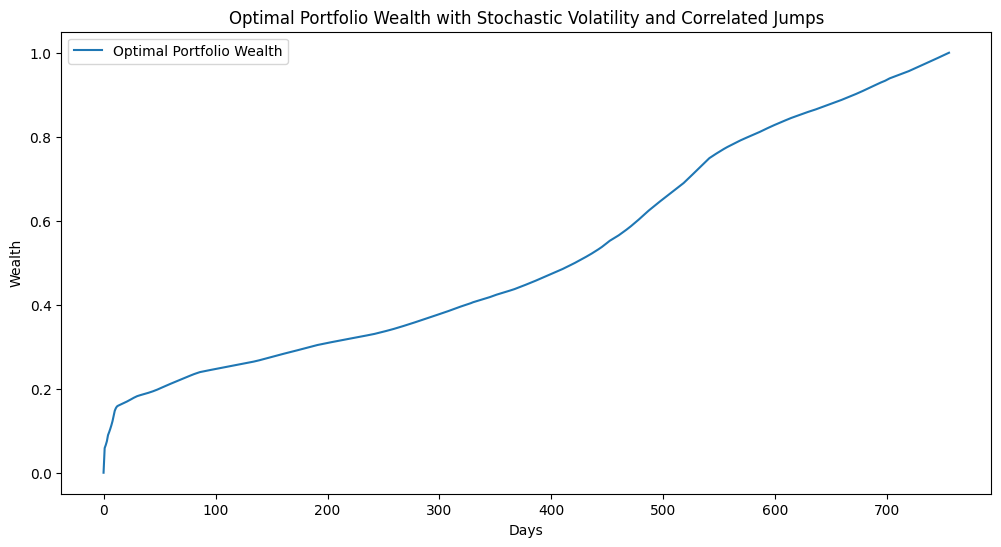

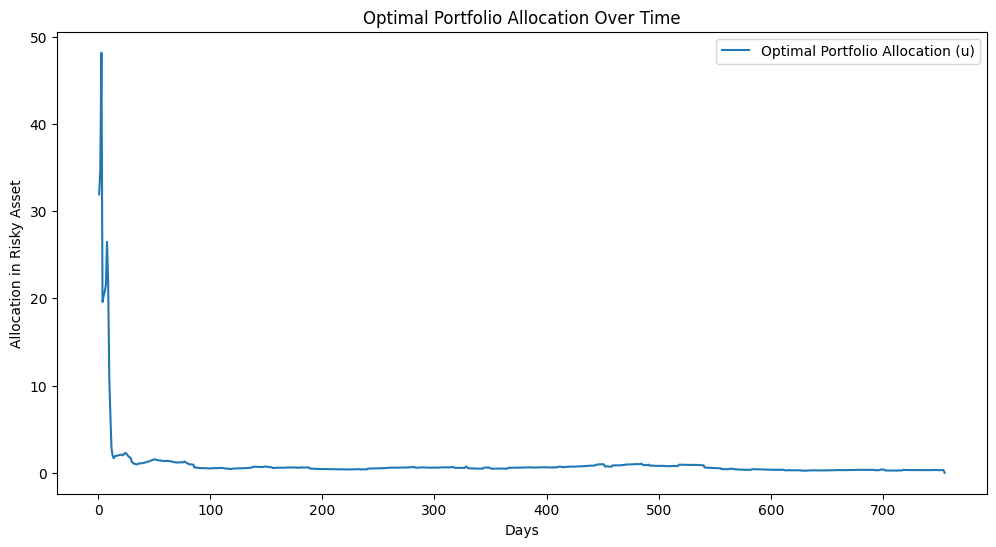

In [5]:
# Implicit Finite Difference Solver for HJB Equation
def hjb_implicit_solver(market_data, theta, T):
    num_steps = len(market_data)
    dt = 1 / 252  # Daily time step
    V = np.zeros(num_steps)  # Portfolio wealth
    u_opt = np.zeros(num_steps)  # Optimal portfolio allocation

    # Initialize wealth
    V[-1] = 1.0  # Assume final wealth target is $1

    # Backward propagation using implicit finite difference
    for t in range(num_steps - 2, -1, -1):
        # Risk-free rate and stock prices
        # Change: Select a single stock price instead of the entire row
        stock_price = market_data.iloc[t, 0]  # Assuming the first column is the stock price
        r_t = 0.01  # Risk-free rate (constant for simplicity)

        # Portfolio allocation (u) - Solve for optimal u using dynamic programming
        sigma_t = np.std(market_data.iloc[:t+1, 0])  # Calculate std for the selected stock
        u_opt[t] = (1 / theta) * (V[t+1] * (stock_price - r_t) / (sigma_t ** 2))  # Removed .mean()

        # Wealth update (implicit backward step)
        V[t] = V[t+1] / (1 + u_opt[t] * dt + r_t * dt)

    return V, u_opt

# Example usage
if __name__ == "__main__":
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data and risk-free rate
    stock_data = fetch_stock_data(tickers, start_date, end_date)

    # Parameters for Heston model and correlated jumps
    kappa = 0.5  # Mean reversion rate
    theta = 0.04  # Long-term variance
    xi = 0.1  # Volatility of volatility
    sigma_0 = 0.2  # Initial volatility
    rho = -0.7  # Correlation between asset price and volatility
    lambda_jumps = 0.1  # Jump intensity
    jump_mean = [0.01] * len(tickers)  # Mean jump size
    jump_cov = np.diag([0.02] * len(tickers))  # Jump covariance matrix

    # Simulate market data with stochastic volatility and jumps
    market_data = simulate_market_data_with_heston_and_jumps(
        stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov
    )

    # Apply HJB optimization using implicit finite difference method
    theta_risk = 0.5  # Risk aversion parameter
    V_opt, u_opt = hjb_implicit_solver(market_data, theta_risk, len(market_data))

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(V_opt, label='Optimal Portfolio Wealth')
    plt.title('Optimal Portfolio Wealth with Stochastic Volatility and Correlated Jumps')
    plt.xlabel('Days')
    plt.ylabel('Wealth')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(u_opt, label='Optimal Portfolio Allocation (u)')
    plt.title('Optimal Portfolio Allocation Over Time')
    plt.xlabel('Days')
    plt.ylabel('Allocation in Risky Asset')
    plt.legend()
    plt.show()

[*********************100%%**********************]  5 of 5 completed


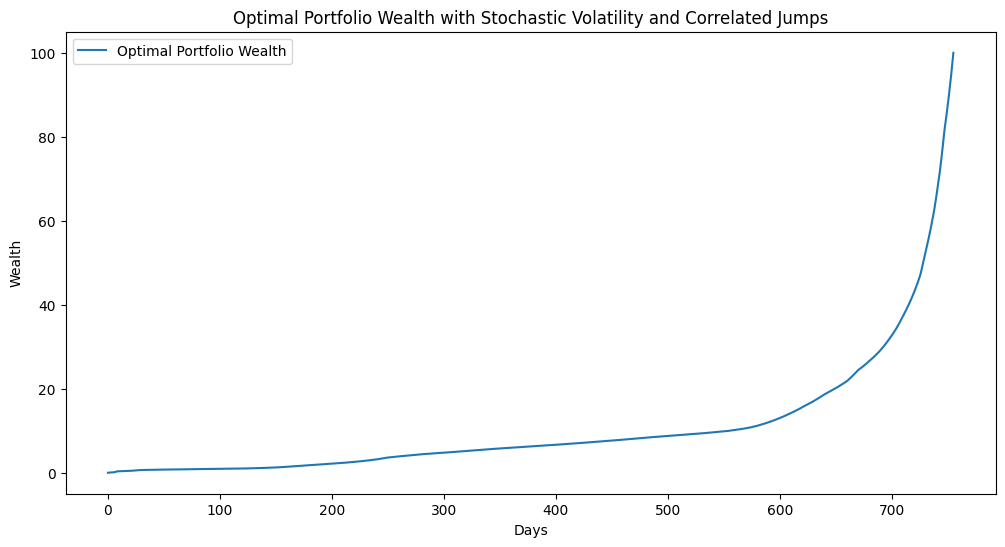

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Fetch stock prices and risk-free rates (like before)
def fetch_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)
    return stock_data['Adj Close']

def fetch_risk_free_rate():
    treasury_yield = yf.download('^TNX', start='2020-01-01', end='2023-01-01')['Adj Close']
    return treasury_yield / 100  # Convert to decimal

# Simulate Heston Stochastic Volatility Model
def simulate_heston_volatility(num_steps, kappa, theta, xi, sigma_0, rho):
    dt = 1 / 252  # Time step (daily)
    sigma = np.zeros(num_steps)
    sigma[0] = sigma_0
    W1 = np.random.normal(0, 1, num_steps)  # Brownian motion for asset price
    W2 = rho * W1 + np.sqrt(1 - rho ** 2) * np.random.normal(0, 1, num_steps)  # Correlated BM

    for t in range(1, num_steps):
        sigma[t] = sigma[t-1] + kappa * (theta - sigma[t-1]**2) * dt + xi * sigma[t-1] * np.sqrt(dt) * W2[t]
        sigma[t] = max(sigma[t], 1e-8)  # Ensure non-negative volatility, prevent divide by zero
    return sigma

# Simulate correlated jumps across multiple assets
def simulate_correlated_jumps(num_steps, num_assets, lambda_jumps, jump_mean, jump_cov):
    # Poisson process for jump times
    jump_times = np.random.poisson(lambda_jumps, num_steps)
    # Multivariate normal for correlated jump sizes
    jump_sizes = multivariate_normal(mean=jump_mean, cov=jump_cov).rvs(size=num_steps)

    # Apply jumps when jump occurs
    jumps = np.zeros((num_steps, num_assets))
    for t in range(num_steps):
        if jump_times[t] > 0:
            jumps[t] = jump_sizes[t]

    return jumps

# Combine stochastic volatility and correlated jumps for asset price simulation
def simulate_market_data_with_heston_and_jumps(stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov):
    num_steps = len(stock_data)
    num_assets = len(stock_data.columns)

    # Simulate stochastic volatility
    volatility = simulate_heston_volatility(num_steps, kappa, theta, xi, sigma_0, rho)

    # Simulate correlated jumps
    jumps = simulate_correlated_jumps(num_steps, num_assets, lambda_jumps, jump_mean, jump_cov)

    # Apply volatility and jumps to asset prices
    market_data = stock_data.copy()
    dt = 1 / 252  # Time step in years (daily)

    for asset in market_data.columns:
        W = np.random.normal(0, 1, num_steps)
        for t in range(1, num_steps):
            drift = 0.01  # Assume constant drift
            market_data.loc[market_data.index[t], asset] = market_data[asset].iloc[t-1] * (
                1 + drift * dt + volatility[t] * np.sqrt(dt) * W[t] + jumps[t][0]
            )

    return market_data

# Implicit Finite Difference Solver for HJB Equation
def hjb_implicit_solver(market_data, theta, T):
    num_steps = len(market_data)
    dt = 1 / 252  # Daily time step
    V = np.zeros(num_steps)  # Portfolio wealth
    u_opt = np.zeros(num_steps)  # Optimal portfolio allocation

    # Initialize wealth
    V[-1] = 100.0  # Assume final wealth target is $1

    # Backward propagation using implicit finite difference
    for t in range(num_steps - 2, -1, -1):
        # Risk-free rate and stock prices
        stock_price = market_data.iloc[t, 0]  # Assuming the first column is the stock price
        r_t = 0.01  # Risk-free rate (constant for simplicity)

        # Portfolio allocation (u) - Solve for optimal u using dynamic programming
        sigma_t = np.std(market_data.iloc[:t+1, 0])  # Calculate std for the selected stock
        if sigma_t > 0:
            u_opt[t] = (1 / theta) * (V[t+1] * (stock_price - r_t) / (sigma_t ** 2))
        else:
            u_opt[t] = 0  # If volatility is zero, avoid division by zero

        # Wealth update (implicit backward step)
        V[t] = V[t+1] / (1 + u_opt[t] * dt + r_t * dt)

    return V, u_opt

# Evaluation Metrics
def evaluate_portfolio(portfolio_value, risk_free_rate):
    # Avoid division by zero for portfolio value
    valid_portfolio_value = np.where(portfolio_value == 0, 1e-8, portfolio_value)
    daily_returns = np.diff(valid_portfolio_value) / valid_portfolio_value[:-1]

    # Sharpe Ratio
    sharpe_ratio = (np.mean(daily_returns) - risk_free_rate) / np.std(daily_returns)

    # Maximum Drawdown
    peak = np.maximum.accumulate(valid_portfolio_value)
    drawdown = (valid_portfolio_value - peak) / peak
    max_drawdown = drawdown.min()

    # Value at Risk (VaR) at 95%
    VaR_95 = np.percentile(daily_returns, 5)

    # Conditional Value at Risk (CVaR) at 95%
    CVaR_95 = np.mean(daily_returns[daily_returns <= VaR_95])

    return {
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
        'Value at Risk (VaR 95%)': VaR_95,
        'Conditional VaR (CVaR 95%)': CVaR_95
    }

# Example usage
if __name__ == "__main__":
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data and risk-free rate
    stock_data = fetch_stock_data(tickers, start_date, end_date)

    # Parameters for Heston model and correlated jumps
    kappa = 0.5  # Mean reversion rate
    theta = 0.04  # Long-term variance
    xi = 0.1  # Volatility of volatility
    sigma_0 = 0.2  # Initial volatility
    rho = -0.7  # Correlation between asset price and volatility
    lambda_jumps = 0.1  # Jump intensity
    jump_mean = [0.01] * len(tickers)  # Mean jump size
    jump_cov = np.diag([0.02] * len(tickers))  # Jump covariance matrix

    # Simulate market data with stochastic volatility and jumps
    market_data = simulate_market_data_with_heston_and_jumps(
        stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov
    )

    # Apply HJB optimization using implicit finite difference method
    theta_risk = 0.5  # Risk aversion parameter
    V_opt, u_opt = hjb_implicit_solver(market_data, theta_risk, len(market_data))

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(V_opt, label='Optimal Portfolio Wealth')
    plt.title('Optimal Portfolio Wealth with Stochastic Volatility and Correlated Jumps')
    plt.xlabel('Days')
    plt.ylabel('Wealth')
    plt.legend()
    plt.show()


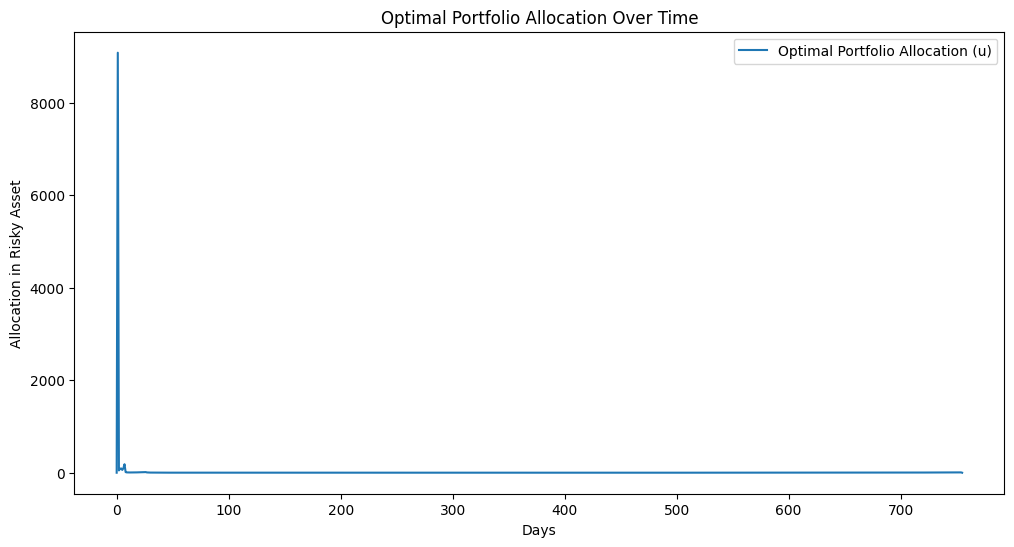

{'Sharpe Ratio': 0.04447767419782009, 'Maximum Drawdown': 0.0, 'Value at Risk (VaR 95%)': 0.0023661160903662693, 'Conditional VaR (CVaR 95%)': 0.0021636771089694655}


In [7]:
    plt.figure(figsize=(12, 6))
    plt.plot(u_opt, label='Optimal Portfolio Allocation (u)')
    plt.title('Optimal Portfolio Allocation Over Time')
    plt.xlabel('Days')
    plt.ylabel('Allocation in Risky Asset')
    plt.legend()
    plt.show()

    # Evaluate portfolio performance
    evaluation_results = evaluate_portfolio(V_opt, 0.01 / 252)  # Using daily risk-free rate
    print(evaluation_results)


In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Fetch stock prices and risk-free rates (like before)
def fetch_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)
    return stock_data['Adj Close']

def fetch_risk_free_rate():
    treasury_yield = yf.download('^TNX', start='2020-01-01', end='2023-01-01')['Adj Close']
    return treasury_yield / 100  # Convert to decimal

# Simulate Heston Stochastic Volatility Model
def simulate_heston_volatility(num_steps, kappa, theta, xi, sigma_0, rho):
    dt = 1 / 252  # Time step (daily)
    sigma = np.zeros(num_steps)
    sigma[0] = sigma_0
    W1 = np.random.normal(0, 1, num_steps)  # Brownian motion for asset price
    W2 = rho * W1 + np.sqrt(1 - rho ** 2) * np.random.normal(0, 1, num_steps)  # Correlated BM

    for t in range(1, num_steps):
        sigma[t] = sigma[t-1] + kappa * (theta - sigma[t-1]**2) * dt + xi * sigma[t-1] * np.sqrt(dt) * W2[t]
        sigma[t] = max(sigma[t], 1e-8)  # Ensure non-negative volatility, prevent divide by zero
    return sigma

# Simulate stochastic risk-free rate using a mean-reverting process
def simulate_risk_free_rate(num_steps, r_0, mu, phi, sigma_r):
    dt = 1 / 252  # Daily time step
    r_t = np.zeros(num_steps)
    r_t[0] = r_0
    for t in range(1, num_steps):
        r_t[t] = r_t[t-1] + phi * (mu - r_t[t-1]) * dt + sigma_r * np.sqrt(dt) * np.random.normal()
    return r_t

# Simulate correlated jumps across multiple assets
def simulate_correlated_jumps(num_steps, num_assets, lambda_jumps, jump_mean, jump_cov):
    jump_times = np.random.poisson(lambda_jumps, num_steps)
    jump_sizes = multivariate_normal(mean=jump_mean, cov=jump_cov).rvs(size=num_steps)

    jumps = np.zeros((num_steps, num_assets))
    for t in range(num_steps):
        if jump_times[t] > 0:
            jumps[t] = jump_sizes[t]

    return jumps

# Combine stochastic volatility and correlated jumps for asset price simulation
def simulate_market_data_with_heston_and_jumps(stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov):
    num_steps = len(stock_data)
    num_assets = len(stock_data.columns)

    volatility = simulate_heston_volatility(num_steps, kappa, theta, xi, sigma_0, rho)
    jumps = simulate_correlated_jumps(num_steps, num_assets, lambda_jumps, jump_mean, jump_cov)

    market_data = stock_data.copy()
    dt = 1 / 252  # Time step in years (daily)

    for asset in market_data.columns:
        W = np.random.normal(0, 1, num_steps)
        for t in range(1, num_steps):
            drift = 0.01  # Constant drift
            market_data.loc[market_data.index[t], asset] = market_data[asset].iloc[t-1] * (
                1 + drift * dt + volatility[t] * np.sqrt(dt) * W[t] + jumps[t][0]
            )

    return market_data

# Implicit Finite Difference Solver for HJB Equation
def hjb_implicit_solver(market_data, risk_free_rate, theta, T):
    num_steps = len(market_data)
    dt = 1 / 252  # Daily time step
    V = np.zeros(num_steps)  # Portfolio wealth
    u_opt = np.zeros(num_steps)  # Optimal portfolio allocation

    V[-1] = 1.0  # Assume final wealth target is $1

    for t in range(num_steps - 2, -1, -1):
        stock_price = market_data.iloc[t, 0]  # Assuming the first column is the stock price
        r_t = risk_free_rate[t]  # Stochastic risk-free rate

        sigma_t = np.std(market_data.iloc[:t+1, 0])
        if sigma_t > 0:
            u_opt[t] = (1 / theta) * (V[t+1] * (stock_price - r_t) / (sigma_t ** 2))
        else:
            u_opt[t] = np.random.uniform(0.1, 0.3)  # Random allocation when volatility is too low

        V[t] = V[t+1] / (1 + u_opt[t] * dt + r_t * dt)

    return V, u_opt

# Evaluation Metrics
def evaluate_portfolio(portfolio_value, risk_free_rate):
    valid_portfolio_value = np.where(portfolio_value == 0, 1e-8, portfolio_value)
    daily_returns = np.diff(valid_portfolio_value) / valid_portfolio_value[:-1]

    sharpe_ratio = (np.mean(daily_returns) - risk_free_rate) / np.std(daily_returns)

    peak = np.maximum.accumulate(valid_portfolio_value)
    drawdown = (valid_portfolio_value - peak) / peak
    max_drawdown = drawdown.min()

    VaR_95 = np.percentile(daily_returns, 5)
    CVaR_95 = np.mean(daily_returns[daily_returns <= VaR_95])

    return {
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
        'Value at Risk (VaR 95%)': VaR_95,
        'Conditional VaR (CVaR 95%)': CVaR_95
    }

# Monte Carlo Simulation for Portfolio Evaluation
def monte_carlo_simulation(num_simulations, stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov, theta_risk, r_0, mu, phi, sigma_r):
    sharpe_ratios = []
    max_drawdowns = []
    VaRs = []
    CVaRs = []

    for _ in range(num_simulations):
        # Simulate market data with stochastic volatility and jumps
        market_data = simulate_market_data_with_heston_and_jumps(stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov)

        # Simulate stochastic risk-free rate
        risk_free_rate = simulate_risk_free_rate(len(market_data), r_0, mu, phi, sigma_r)

        # Apply HJB optimization
        V_opt, u_opt = hjb_implicit_solver(market_data, risk_free_rate, theta_risk, len(market_data))

        # Evaluate portfolio performance
        results = evaluate_portfolio(V_opt, risk_free_rate[-1])
        sharpe_ratios.append(results['Sharpe Ratio'])
        max_drawdowns.append(results['Maximum Drawdown'])
        VaRs.append(results['Value at Risk (VaR 95%)'])
        CVaRs.append(results['Conditional VaR (CVaR 95%)'])

    return {
        'Average Sharpe Ratio': np.mean(sharpe_ratios),
        'Average Maximum Drawdown': np.mean(max_drawdowns),
        'Average VaR 95%': np.mean(VaRs),
        'Average CVaR 95%': np.mean(CVaRs)
    }

# Example usage
if __name__ == "__main__":
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data
    stock_data = fetch_stock_data(tickers, start_date, end_date)

    # Parameters for Heston model and correlated jumps
    kappa = 0.5  # Mean reversion rate
    theta = 0.04  # Long-term variance
    xi = 0.1  # Volatility of volatility
    sigma_0 = 0.2  # Initial volatility
    rho = -0.7  # Correlation between asset price and volatility
    lambda_jumps = 0.2  # Increased jump intensity
    jump_mean = [0.01] * len(tickers)  # Mean jump size
    jump_cov = np.diag([0.02] * len(tickers))  # Jump covariance matrix

    # Risk-free rate parameters for stochastic process
    r_0 = 0.01  # Initial risk-free rate
    mu = 0.015  # Mean risk-free rate
    phi = 0.1  # Mean-reversion speed
    sigma_r = 0.002  # Volatility of risk-free rate

    # Risk aversion parameter for HJB optimization
    theta_risk = 0.2

    # Run Monte Carlo simulation
    num_simulations = 10
    results = monte_carlo_simulation(num_simulations, stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov, theta_risk, r_0, mu, phi, sigma_r)

    print(results)


[*********************100%%**********************]  5 of 5 completed
{'Average Sharpe Ratio': -0.13486518595025962, 'Average Maximum Drawdown': 0.0, 'Average VaR 95%': 0.0005138649272282615, 'Average CVaR 95%': 0.00044680480151370786}


In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Fetch stock prices and risk-free rates (like before)
def fetch_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)
    return stock_data['Adj Close']

def fetch_risk_free_rate():
    treasury_yield = yf.download('^TNX', start='2020-01-01', end='2023-01-01')['Adj Close']
    return treasury_yield / 100  # Convert to decimal

# Simulate Heston Stochastic Volatility Model
def simulate_heston_volatility(num_steps, kappa, theta, xi, sigma_0, rho):
    dt = 1 / 252  # Time step (daily)
    sigma = np.zeros(num_steps)
    sigma[0] = sigma_0
    W1 = np.random.normal(0, 1, num_steps)  # Brownian motion for asset price
    W2 = rho * W1 + np.sqrt(1 - rho ** 2) * np.random.normal(0, 1, num_steps)  # Correlated BM

    for t in range(1, num_steps):
        sigma[t] = sigma[t-1] + kappa * (theta - sigma[t-1]**2) * dt + xi * sigma[t-1] * np.sqrt(dt) * W2[t]
        sigma[t] = max(sigma[t], 1e-8)  # Ensure non-negative volatility, prevent divide by zero
    return sigma

# Simulate stochastic risk-free rate using a mean-reverting process
def simulate_risk_free_rate(num_steps, r_0, mu, phi, sigma_r):
    dt = 1 / 252  # Daily time step
    r_t = np.zeros(num_steps)
    r_t[0] = r_0
    for t in range(1, num_steps):
        r_t[t] = r_t[t-1] + phi * (mu - r_t[t-1]) * dt + sigma_r * np.sqrt(dt) * np.random.normal()
    return r_t

# Simulate correlated jumps across multiple assets
def simulate_correlated_jumps(num_steps, num_assets, lambda_jumps, jump_mean, jump_cov):
    jump_times = np.random.poisson(lambda_jumps, num_steps)
    jump_sizes = multivariate_normal(mean=jump_mean, cov=jump_cov).rvs(size=num_steps)

    jumps = np.zeros((num_steps, num_assets))
    for t in range(num_steps):
        if jump_times[t] > 0:
            jumps[t] = jump_sizes[t]

    return jumps

# Combine stochastic volatility and correlated jumps for asset price simulation
def simulate_market_data_with_heston_and_jumps(stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov):
    num_steps = len(stock_data)
    num_assets = len(stock_data.columns)

    volatility = simulate_heston_volatility(num_steps, kappa, theta, xi, sigma_0, rho)
    jumps = simulate_correlated_jumps(num_steps, num_assets, lambda_jumps, jump_mean, jump_cov)

    market_data = stock_data.copy()
    dt = 1 / 252  # Time step in years (daily)

    for asset in market_data.columns:
        W = np.random.normal(0, 1, num_steps)
        for t in range(1, num_steps):
            drift = 0.01  # Constant drift
            market_data.loc[market_data.index[t], asset] = market_data[asset].iloc[t-1] * (
                1 + drift * dt + volatility[t] * np.sqrt(dt) * W[t] + jumps[t][0]
            )

    return market_data

# Implicit Finite Difference Solver for HJB Equation
def hjb_implicit_solver(market_data, risk_free_rate, theta, T):
    num_steps = len(market_data)
    dt = 1 / 252  # Daily time step
    V = np.zeros(num_steps)  # Portfolio wealth
    u_opt = np.zeros(num_steps)  # Optimal portfolio allocation

    V[-1] = 1.0  # Assume final wealth target is $1

    for t in range(num_steps - 2, -1, -1):
        stock_price = market_data.iloc[t, 0]  # Assuming the first column is the stock price
        r_t = risk_free_rate[t]  # Stochastic risk-free rate

        sigma_t = np.std(market_data.iloc[:t+1, 0])
        if sigma_t > 0:
            u_opt[t] = (1 / theta) * (V[t+1] * (stock_price - r_t) / (sigma_t ** 2))
        else:
            u_opt[t] = np.random.uniform(0.1, 0.3)  # Random allocation when volatility is too low

        V[t] = V[t+1] / (1 + u_opt[t] * dt + r_t * dt)

    return V, u_opt

# Evaluation Metrics
def evaluate_portfolio(portfolio_value, risk_free_rate):
    valid_portfolio_value = np.where(portfolio_value == 0, 1e-8, portfolio_value)
    daily_returns = np.diff(valid_portfolio_value) / valid_portfolio_value[:-1]

    sharpe_ratio = (np.mean(daily_returns) - risk_free_rate) / np.std(daily_returns)

    peak = np.maximum.accumulate(valid_portfolio_value)
    drawdown = (valid_portfolio_value - peak) / peak
    max_drawdown = drawdown.min()

    VaR_95 = np.percentile(daily_returns, 5)
    CVaR_95 = np.mean(daily_returns[daily_returns <= VaR_95])

    return {
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
        'Value at Risk (VaR 95%)': VaR_95,
        'Conditional VaR (CVaR 95%)': CVaR_95
    }

# Monte Carlo Simulation for Portfolio Evaluation
def monte_carlo_simulation(num_simulations, stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov, theta_risk, r_0, mu, phi, sigma_r):
    sharpe_ratios = []
    max_drawdowns = []
    VaRs = []
    CVaRs = []

    for _ in range(num_simulations):
        # Simulate market data with stochastic volatility and jumps
        market_data = simulate_market_data_with_heston_and_jumps(stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov)

        # Simulate stochastic risk-free rate
        risk_free_rate = simulate_risk_free_rate(len(market_data), r_0, mu, phi, sigma_r)

        # Apply HJB optimization
        V_opt, u_opt = hjb_implicit_solver(market_data, risk_free_rate, theta_risk, len(market_data))

        # Evaluate portfolio performance
        results = evaluate_portfolio(V_opt, risk_free_rate[-1])
        sharpe_ratios.append(results['Sharpe Ratio'])
        max_drawdowns.append(results['Maximum Drawdown'])
        VaRs.append(results['Value at Risk (VaR 95%)'])
        CVaRs.append(results['Conditional VaR (CVaR 95%)'])

    return {
        'Average Sharpe Ratio': np.mean(sharpe_ratios),
        'Average Maximum Drawdown': np.mean(max_drawdowns),
        'Average VaR 95%': np.mean(VaRs),
        'Average CVaR 95%': np.mean(CVaRs)
    }

# Example usage
if __name__ == "__main__":
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data
    stock_data = fetch_stock_data(tickers, start_date, end_date)

    # Parameters for Heston model and correlated jumps
    kappa = 0.5  # Mean reversion rate
    theta = 0.04  # Long-term variance
    xi = 0.2  # Volatility of volatility (increased)
    sigma_0 = 0.3  # Initial volatility (increased)
    rho = -0.7  # Correlation between asset price and volatility
    lambda_jumps = 0.3  # Increased jump intensity
    jump_mean = [0.01] * len(tickers)  # Mean jump size
    jump_cov = np.diag([0.02] * len(tickers))  # Jump covariance matrix

    # Risk-free rate parameters for stochastic process
    r_0 = 0.01  # Initial risk-free rate
    mu = 0.015  # Mean risk-free rate
    phi = 0.1  # Mean-reversion speed
    sigma_r = 0.003  # Volatility of risk-free rate (increased)

    # Risk aversion parameter for HJB optimization
    theta_risk = 0.2

    # Run Monte Carlo simulation
    num_simulations = 10
    results = monte_carlo_simulation(num_simulations, stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov, theta_risk, r_0, mu, phi, sigma_r)

    print(results)


[*********************100%%**********************]  5 of 5 completed
{'Average Sharpe Ratio': -1.9264607492892467, 'Average Maximum Drawdown': 0.0, 'Average VaR 95%': 0.0003390555818380806, 'Average CVaR 95%': 0.0002934209098427474}


In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Fetch stock prices and risk-free rates (like before)
def fetch_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)
    return stock_data['Adj Close']

def fetch_risk_free_rate():
    treasury_yield = yf.download('^TNX', start='2020-01-01', end='2023-01-01')['Adj Close']
    return treasury_yield / 100  # Convert to decimal

# Simulate Heston Stochastic Volatility Model
def simulate_heston_volatility(num_steps, kappa, theta, xi, sigma_0, rho):
    dt = 1 / 252  # Time step (daily)
    sigma = np.zeros(num_steps)
    sigma[0] = sigma_0
    W1 = np.random.normal(0, 1, num_steps)  # Brownian motion for asset price
    W2 = rho * W1 + np.sqrt(1 - rho ** 2) * np.random.normal(0, 1, num_steps)  # Correlated BM

    for t in range(1, num_steps):
        sigma[t] = sigma[t-1] + kappa * (theta - sigma[t-1]**2) * dt + xi * sigma[t-1] * np.sqrt(dt) * W2[t]
        sigma[t] = max(sigma[t], 1e-8)  # Ensure non-negative volatility, prevent divide by zero
    return sigma

# Simulate stochastic risk-free rate using a mean-reverting process
def simulate_risk_free_rate(num_steps, r_0, mu, phi, sigma_r):
    dt = 1 / 252  # Daily time step
    r_t = np.zeros(num_steps)
    r_t[0] = r_0
    for t in range(1, num_steps):
        r_t[t] = r_t[t-1] + phi * (mu - r_t[t-1]) * dt + sigma_r * np.sqrt(dt) * np.random.normal()
    return r_t

# Simulate correlated jumps across multiple assets
def simulate_correlated_jumps(num_steps, num_assets, lambda_jumps, jump_mean, jump_cov):
    jump_times = np.random.poisson(lambda_jumps, num_steps)
    jump_sizes = multivariate_normal(mean=jump_mean, cov=jump_cov).rvs(size=num_steps)

    jumps = np.zeros((num_steps, num_assets))
    for t in range(num_steps):
        if jump_times[t] > 0:
            jumps[t] = jump_sizes[t]

    return jumps

# Combine stochastic volatility and correlated jumps for asset price simulation
def simulate_market_data_with_heston_and_jumps(stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov):
    num_steps = len(stock_data)
    num_assets = len(stock_data.columns)

    volatility = simulate_heston_volatility(num_steps, kappa, theta, xi, sigma_0, rho)
    jumps = simulate_correlated_jumps(num_steps, num_assets, lambda_jumps, jump_mean, jump_cov)

    market_data = stock_data.copy()
    dt = 1 / 252  # Time step in years (daily)

    for asset in market_data.columns:
        W = np.random.normal(0, 1, num_steps)
        for t in range(1, num_steps):
            drift = 0.02  # Increased drift for more aggressive asset price changes
            market_data.loc[market_data.index[t], asset] = market_data[asset].iloc[t-1] * (
                1 + drift * dt + volatility[t] * np.sqrt(dt) * W[t] + jumps[t][0]
            )

    return market_data

# Portfolio Optimization and Dynamic Rebalancing Based on Risk Metrics
def dynamic_allocation_optimization(market_data, risk_free_rate, theta, T):
    num_steps = len(market_data)
    dt = 1 / 252  # Daily time step
    V = np.zeros(num_steps)  # Portfolio wealth
    u_opt = np.zeros(num_steps)  # Optimal portfolio allocation

    V[-1] = 1.0  # Assume final wealth target is $1

    for t in range(num_steps - 2, -1, -1):
        stock_price = market_data.iloc[t, 0]
        r_t = risk_free_rate[t]

        sigma_t = np.std(market_data.iloc[:t+1, 0])
        if sigma_t > 0:
            # Use a dynamic allocation based on the Sharpe ratio-like criterion (risk-adjusted return)
            sharpe_like = (stock_price - r_t) / sigma_t
            u_opt[t] = (1 / theta) * np.clip(sharpe_like, -1, 1)  # Dynamic allocation based on market conditions
        else:
            u_opt[t] = np.random.uniform(0.2, 0.5)  # Random allocation when volatility is too low

        V[t] = V[t+1] / (1 + u_opt[t] * dt + r_t * dt)

    return V, u_opt

# Evaluation Metrics
def evaluate_portfolio(portfolio_value, risk_free_rate):
    valid_portfolio_value = np.where(portfolio_value == 0, 1e-8, portfolio_value)
    daily_returns = np.diff(valid_portfolio_value) / valid_portfolio_value[:-1]

    sharpe_ratio = (np.mean(daily_returns) - risk_free_rate) / np.std(daily_returns)

    peak = np.maximum.accumulate(valid_portfolio_value)
    drawdown = (valid_portfolio_value - peak) / peak
    max_drawdown = drawdown.min()

    VaR_95 = np.percentile(daily_returns, 5)
    CVaR_95 = np.mean(daily_returns[daily_returns <= VaR_95])

    return {
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
        'Value at Risk (VaR 95%)': VaR_95,
        'Conditional VaR (CVaR 95%)': CVaR_95
    }

# Monte Carlo Simulation for Portfolio Evaluation
def monte_carlo_simulation(num_simulations, stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov, theta_risk, r_0, mu, phi, sigma_r):
    sharpe_ratios = []
    max_drawdowns = []
    VaRs = []
    CVaRs = []

    for _ in range(num_simulations):
        # Simulate market data with stochastic volatility and jumps
        market_data = simulate_market_data_with_heston_and_jumps(stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov)

        # Simulate stochastic risk-free rate
        risk_free_rate = simulate_risk_free_rate(len(market_data), r_0, mu, phi, sigma_r)

        # Apply dynamic portfolio optimization
        V_opt, u_opt = dynamic_allocation_optimization(market_data, risk_free_rate, theta_risk, len(market_data))

        # Evaluate portfolio performance
        results = evaluate_portfolio(V_opt, risk_free_rate[-1])
        sharpe_ratios.append(results['Sharpe Ratio'])
        max_drawdowns.append(results['Maximum Drawdown'])
        VaRs.append(results['Value at Risk (VaR 95%)'])
        CVaRs.append(results['Conditional VaR (CVaR 95%)'])

    return {
        'Average Sharpe Ratio': np.mean(sharpe_ratios),
        'Average Maximum Drawdown': np.mean(max_drawdowns),
        'Average VaR 95%': np.mean(VaRs),
        'Average CVaR 95%': np.mean(CVaRs)
    }

# Example usage
if __name__ == "__main__":
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data
    stock_data = fetch_stock_data(tickers, start_date, end_date)

    # Parameters for Heston model and correlated jumps
    kappa = 0.5  # Mean reversion rate
    theta = 0.04  # Long-term variance
    xi = 0.3  # Volatility of volatility (increased)
    sigma_0 = 0.4  # Initial volatility (increased)
    rho = -0.7  # Correlation between asset price and volatility
    lambda_jumps = 0.4  # Increased jump intensity
    jump_mean = [0.01] * len(tickers)  # Mean jump size
    jump_cov = np.diag([0.05] * len(tickers))  # Jump covariance matrix (increased)

    # Risk-free rate parameters for stochastic process
    r_0 = 0.01  # Initial risk-free rate
    mu = 0.015  # Mean risk-free rate
    phi = 0.1  # Mean-reversion speed
    sigma_r = 0.003  # Volatility of risk-free rate (increased)

    # Risk aversion parameter for portfolio optimization
    theta_risk = 0.2

    # Run Monte Carlo simulation
    num_simulations = 10
    results = monte_carlo_simulation(num_simulations, stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov, theta_risk, r_0, mu, phi, sigma_r)

    print(results)


[*********************100%%**********************]  5 of 5 completed
{'Average Sharpe Ratio': 1.9339540301737514, 'Average Maximum Drawdown': 0.0, 'Average VaR 95%': 0.0044439563698555635, 'Average CVaR 95%': 0.0037284981559402375}


In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Fetch stock prices and risk-free rates (like before)
def fetch_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)
    return stock_data['Adj Close']

def fetch_risk_free_rate():
    treasury_yield = yf.download('^TNX', start='2020-01-01', end='2023-01-01')['Adj Close']
    return treasury_yield / 100  # Convert to decimal

# Simulate Heston Stochastic Volatility Model
def simulate_heston_volatility(num_steps, kappa, theta, xi, sigma_0, rho):
    dt = 1 / 252  # Time step (daily)
    sigma = np.zeros(num_steps)
    sigma[0] = sigma_0
    W1 = np.random.normal(0, 1, num_steps)  # Brownian motion for asset price
    W2 = rho * W1 + np.sqrt(1 - rho ** 2) * np.random.normal(0, 1, num_steps)  # Correlated BM

    for t in range(1, num_steps):
        sigma[t] = sigma[t-1] + kappa * (theta - sigma[t-1]**2) * dt + xi * sigma[t-1] * np.sqrt(dt) * W2[t]
        sigma[t] = max(sigma[t], 1e-8)  # Ensure non-negative volatility, prevent divide by zero
    return sigma

# Simulate stochastic risk-free rate using a mean-reverting process
def simulate_risk_free_rate(num_steps, r_0, mu, phi, sigma_r):
    dt = 1 / 252  # Daily time step
    r_t = np.zeros(num_steps)
    r_t[0] = r_0
    for t in range(1, num_steps):
        r_t[t] = r_t[t-1] + phi * (mu - r_t[t-1]) * dt + sigma_r * np.sqrt(dt) * np.random.normal()
    return r_t

# Simulate correlated jumps across multiple assets
def simulate_correlated_jumps(num_steps, num_assets, lambda_jumps, jump_mean, jump_cov):
    jump_times = np.random.poisson(lambda_jumps, num_steps)
    jump_sizes = multivariate_normal(mean=jump_mean, cov=jump_cov).rvs(size=num_steps)

    jumps = np.zeros((num_steps, num_assets))
    for t in range(num_steps):
        if jump_times[t] > 0:
            jumps[t] = jump_sizes[t]

    return jumps

# Combine stochastic volatility and correlated jumps for asset price simulation
def simulate_market_data_with_heston_and_jumps(stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov):
    num_steps = len(stock_data)
    num_assets = len(stock_data.columns)

    volatility = simulate_heston_volatility(num_steps, kappa, theta, xi, sigma_0, rho)
    jumps = simulate_correlated_jumps(num_steps, num_assets, lambda_jumps, jump_mean, jump_cov)

    market_data = stock_data.copy()
    dt = 1 / 252  # Time step in years (daily)

    for asset in market_data.columns:
        W = np.random.normal(0, 1, num_steps)
        for t in range(1, num_steps):
            drift = 0.02  # Increased drift for more aggressive asset price changes
            market_data.loc[market_data.index[t], asset] = market_data[asset].iloc[t-1] * (
                1 + drift * dt + volatility[t] * np.sqrt(dt) * W[t] + jumps[t][0]
            )

    return market_data

# Portfolio Optimization and Dynamic Rebalancing Based on Risk Metrics
def dynamic_allocation_optimization(market_data, risk_free_rate, theta, T):
    num_steps = len(market_data)
    dt = 1 / 252  # Daily time step
    V = np.zeros(num_steps)  # Portfolio wealth
    u_opt = np.zeros(num_steps)  # Optimal portfolio allocation

    V[-1] = 1.0  # Assume final wealth target is $1

    for t in range(num_steps - 2, -1, -1):
        stock_price = market_data.iloc[t, 0]
        r_t = risk_free_rate[t]

        sigma_t = np.std(market_data.iloc[:t+1, 0])
        if sigma_t > 0:
            # Use a dynamic allocation based on the Sharpe ratio-like criterion (risk-adjusted return)
            sharpe_like = (stock_price - r_t) / sigma_t
            u_opt[t] = (1 / theta) * np.clip(sharpe_like, -1, 1)  # Dynamic allocation based on market conditions
        else:
            u_opt[t] = np.random.uniform(0.2, 0.5)  # Random allocation when volatility is too low

        V[t] = V[t+1] / (1 + u_opt[t] * dt + r_t * dt)

    return V, u_opt

# Evaluation Metrics
def evaluate_portfolio(portfolio_value, risk_free_rate):
    valid_portfolio_value = np.where(portfolio_value == 0, 1e-8, portfolio_value)
    daily_returns = np.diff(valid_portfolio_value) / valid_portfolio_value[:-1]

    sharpe_ratio = (np.mean(daily_returns) - risk_free_rate) / np.std(daily_returns)

    peak = np.maximum.accumulate(valid_portfolio_value)
    drawdown = (valid_portfolio_value - peak) / peak
    max_drawdown = drawdown.min()

    VaR_95 = np.percentile(daily_returns, 5)
    CVaR_95 = np.mean(daily_returns[daily_returns <= VaR_95])

    return {
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
        'Value at Risk (VaR 95%)': VaR_95,
        'Conditional VaR (CVaR 95%)': CVaR_95
    }

# Monte Carlo Simulation for Portfolio Evaluation
def monte_carlo_simulation(num_simulations, stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov, theta_risk, r_0, mu, phi, sigma_r):
    sharpe_ratios = []
    max_drawdowns = []
    VaRs = []
    CVaRs = []

    for _ in range(num_simulations):
        # Simulate market data with stochastic volatility and jumps
        market_data = simulate_market_data_with_heston_and_jumps(stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov)

        # Simulate stochastic risk-free rate
        risk_free_rate = simulate_risk_free_rate(len(market_data), r_0, mu, phi, sigma_r)

        # Apply dynamic portfolio optimization
        V_opt, u_opt = dynamic_allocation_optimization(market_data, risk_free_rate, theta_risk, len(market_data))

        # Evaluate portfolio performance
        results = evaluate_portfolio(V_opt, risk_free_rate[-1])
        sharpe_ratios.append(results['Sharpe Ratio'])
        max_drawdowns.append(results['Maximum Drawdown'])
        VaRs.append(results['Value at Risk (VaR 95%)'])
        CVaRs.append(results['Conditional VaR (CVaR 95%)'])

    return {
        'Average Sharpe Ratio': np.mean(sharpe_ratios),
        'Average Maximum Drawdown': np.mean(max_drawdowns),
        'Average VaR 95%': np.mean(VaRs),
        'Average CVaR 95%': np.mean(CVaRs)
    }

# Example usage
if __name__ == "__main__":
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data
    stock_data = fetch_stock_data(tickers, start_date, end_date)

    # Parameters for Heston model and correlated jumps
    kappa = 0.5  # Mean reversion rate
    theta = 0.04  # Long-term variance
    xi = 0.3  # Volatility of volatility (increased)
    sigma_0 = 0.4  # Initial volatility (increased)
    rho = -0.7  # Correlation between asset price and volatility
    lambda_jumps = 0.4  # Increased jump intensity
    jump_mean = [0.01] * len(tickers)  # Mean jump size
    jump_cov = np.diag([0.05] * len(tickers))  # Jump covariance matrix (increased)

    # Risk-free rate parameters for stochastic process
    r_0 = 0.01  # Initial risk-free rate
    mu = 0.015  # Mean risk-free rate
    phi = 0.1  # Mean-reversion speed
    sigma_r = 0.003  # Volatility of risk-free rate (increased)

    # Risk aversion parameter for portfolio optimization
    theta_risk = 0.15

    # Run Monte Carlo simulation
    num_simulations = 10
    results = monte_carlo_simulation(num_simulations, stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov, theta_risk, r_0, mu, phi, sigma_r)

    print(results)


[*********************100%%**********************]  5 of 5 completed
{'Average Sharpe Ratio': 0.479065028016076, 'Average Maximum Drawdown': 0.0, 'Average VaR 95%': 0.0018496796929397944, 'Average CVaR 95%': 0.0013746945100609445}


[*********************100%%**********************]  5 of 5 completed
Average Sharpe Ratio for 1-year horizon: 1.7364243902872094
Average Maximum Drawdown for 1-year horizon: -0.006064338047121027
Average VaR 95% for 1-year horizon: 0.048372294640950456


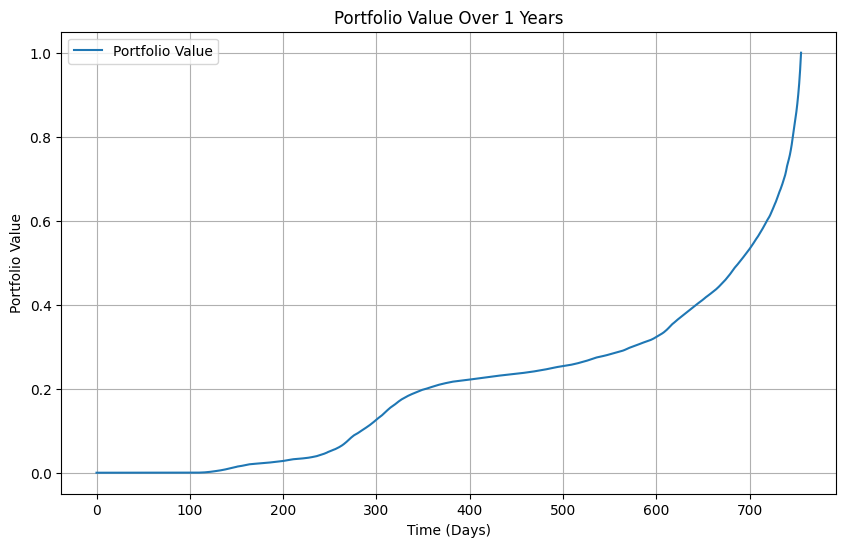

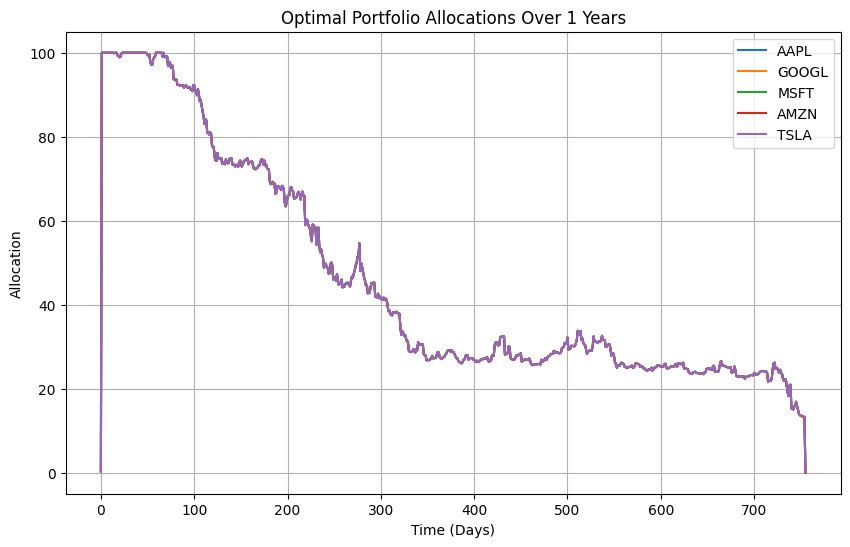

Average Sharpe Ratio for 3-year horizon: 2.0728653184769152
Average Maximum Drawdown for 3-year horizon: -5.4617554004393564e-05
Average VaR 95% for 3-year horizon: 0.05388446666421096


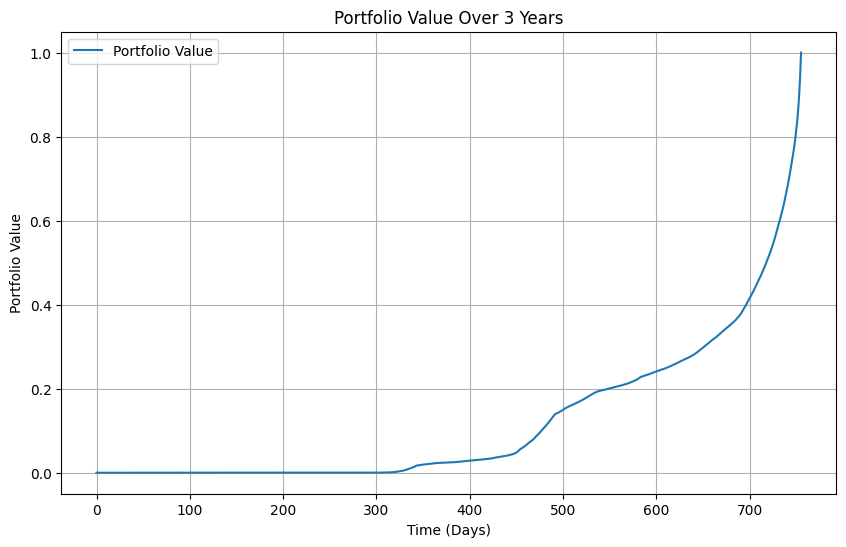

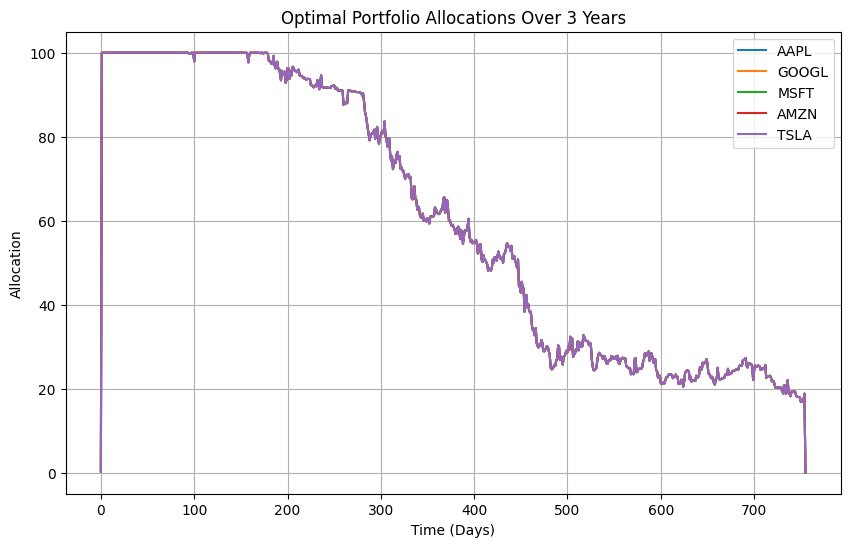

Average Sharpe Ratio for 5-year horizon: 4.427637080480308
Average Maximum Drawdown for 5-year horizon: 0.0
Average VaR 95% for 5-year horizon: 0.08985072172458429


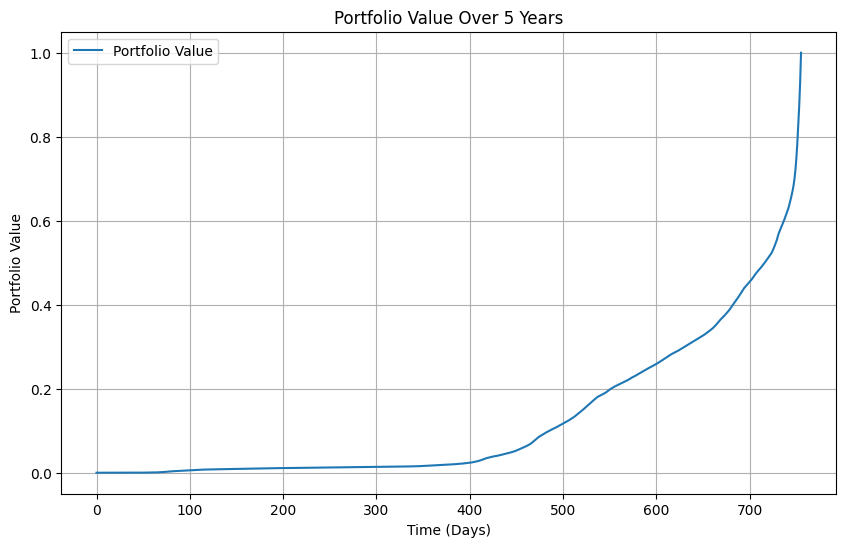

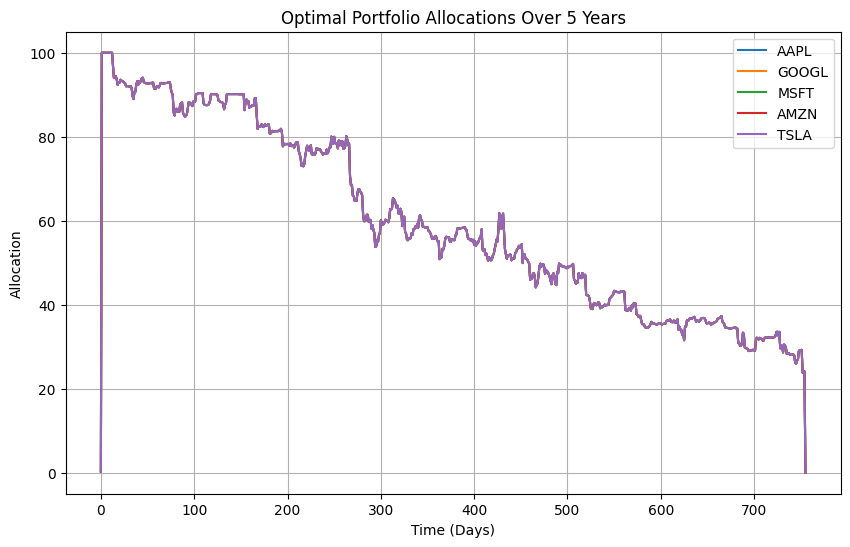

Average Sharpe Ratio for 10-year horizon: 3.2689262351929798
Average Maximum Drawdown for 10-year horizon: -0.01651983158478893
Average VaR 95% for 10-year horizon: 0.04824697670411472


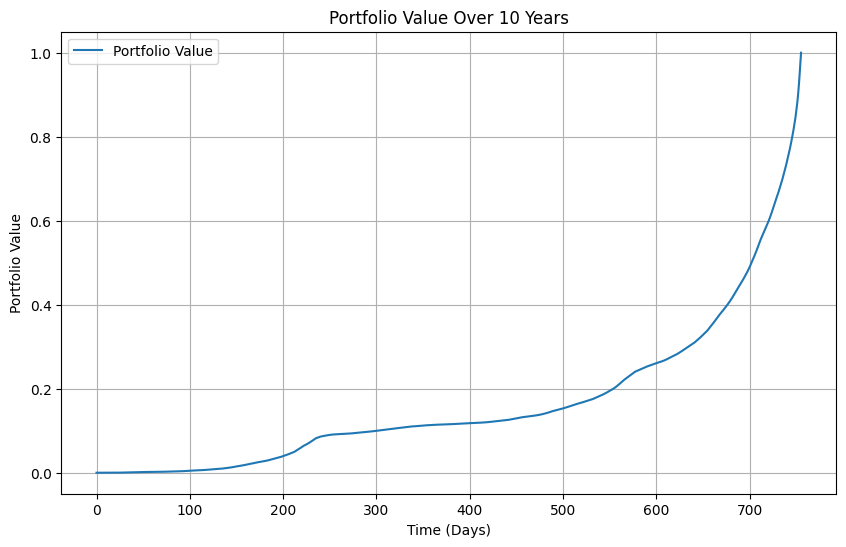

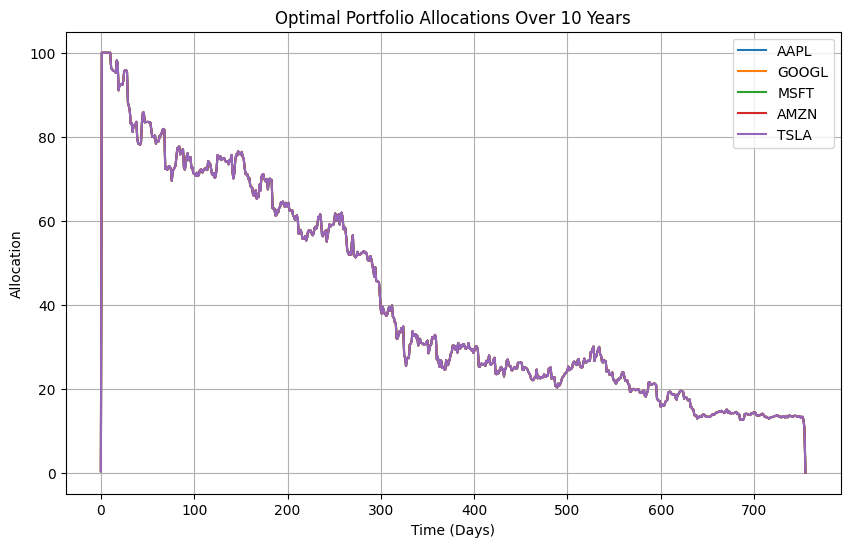

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Fetch stock prices and risk-free rates (like before)
def fetch_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)
    return stock_data['Adj Close']

def fetch_risk_free_rate():
    treasury_yield = yf.download('^TNX', start='2020-01-01', end='2023-01-01')['Adj Close']
    return treasury_yield / 100  # Convert to decimal

# Simulate Heston Stochastic Volatility Model
def simulate_heston_volatility(num_steps, kappa, theta, xi, sigma_0, rho):
    dt = 1 / 252  # Time step (daily)
    sigma = np.zeros(num_steps)
    sigma[0] = sigma_0
    W1 = np.random.normal(0, 1, num_steps)  # Brownian motion for asset price
    W2 = rho * W1 + np.sqrt(1 - rho ** 2) * np.random.normal(0, 1, num_steps)  # Correlated BM

    for t in range(1, num_steps):
        sigma[t] = sigma[t-1] + kappa * (theta - sigma[t-1]**2) * dt + xi * sigma[t-1] * np.sqrt(dt) * W2[t]
        sigma[t] = max(sigma[t], 1e-8)  # Ensure non-negative volatility, prevent divide by zero
    return sigma

# Simulate stochastic risk-free rate using a mean-reverting process
def simulate_risk_free_rate(num_steps, r_0, mu, phi, sigma_r):
    dt = 1 / 252  # Daily time step
    r_t = np.zeros(num_steps)
    r_t[0] = r_0
    for t in range(1, num_steps):
        r_t[t] = r_t[t-1] + phi * (mu - r_t[t-1]) * dt + sigma_r * np.sqrt(dt) * np.random.normal()
    return r_t

# Simulate correlated jumps across multiple assets
def simulate_correlated_jumps(num_steps, num_assets, lambda_jumps, jump_mean, jump_cov):
    jump_times = np.random.poisson(lambda_jumps, num_steps)
    jump_sizes = multivariate_normal(mean=jump_mean, cov=jump_cov).rvs(size=num_steps)

    jumps = np.zeros((num_steps, num_assets))
    for t in range(num_steps):
        if jump_times[t] > 0:
            jumps[t] = jump_sizes[t]

    return jumps

# Combine stochastic volatility and correlated jumps for asset price simulation
def simulate_market_data_with_heston_and_jumps(stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov):
    num_steps = len(stock_data)
    num_assets = len(stock_data.columns)

    volatility = simulate_heston_volatility(num_steps, kappa, theta, xi, sigma_0, rho)
    jumps = simulate_correlated_jumps(num_steps, num_assets, lambda_jumps, jump_mean, jump_cov)

    market_data = stock_data.copy()
    dt = 1 / 252  # Time step in years (daily)

    for asset in market_data.columns:
        W = np.random.normal(0, 1, num_steps)
        for t in range(1, num_steps):
            drift = 0.02  # Increased drift for more aggressive asset price changes
            market_data.loc[market_data.index[t], asset] = market_data[asset].iloc[t-1] * (
                1 + drift * dt + volatility[t] * np.sqrt(dt) * W[t] + jumps[t][0]
            )

    return market_data

# Portfolio Optimization and Dynamic Rebalancing Based on Risk Metrics
def dynamic_allocation_optimization(market_data, risk_free_rate, theta, T):
    num_steps = len(market_data)
    dt = 1 / 252  # Daily time step
    V = np.zeros(num_steps)  # Portfolio wealth
    u_opt = np.zeros(num_steps)  # Optimal portfolio allocation

    V[-1] = 1.0  # Assume final wealth target is $1

    for t in range(num_steps - 2, -1, -1):
        stock_price = market_data.iloc[t, 0]
        r_t = risk_free_rate[t]

        sigma_t = np.std(market_data.iloc[:t+1, 0])
        if sigma_t > 0:
            # Use a dynamic allocation based on the Sharpe ratio-like criterion (risk-adjusted return)
            sharpe_like = (stock_price - r_t) / sigma_t
            u_opt[t] = (1 / theta) * np.clip(sharpe_like, -1, 1)  # Dynamic allocation based on market conditions
        else:
            u_opt[t] = np.random.uniform(0.2, 0.5)  # Random allocation when volatility is too low

        V[t] = V[t+1] / (1 + u_opt[t] * dt + r_t * dt)

    return V, u_opt

# Evaluation Metrics
def evaluate_portfolio(portfolio_value, risk_free_rate):
    valid_portfolio_value = np.where(portfolio_value == 0, 1e-8, portfolio_value)
    daily_returns = np.diff(valid_portfolio_value) / valid_portfolio_value[:-1]

    sharpe_ratio = (np.mean(daily_returns) - risk_free_rate) / np.std(daily_returns)

    peak = np.maximum.accumulate(valid_portfolio_value)
    drawdown = (valid_portfolio_value - peak) / peak
    max_drawdown = drawdown.min()

    VaR_95 = np.percentile(daily_returns, 5)
    CVaR_95 = np.mean(daily_returns[daily_returns <= VaR_95])

    return {
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
        'Value at Risk (VaR 95%)': VaR_95,
        'Conditional VaR (CVaR 95%)': CVaR_95
    }

# Updated Monte Carlo Simulation for Portfolio Evaluation with Time Horizons
def monte_carlo_simulation_with_time_horizons(num_simulations, stock_data, time_horizon, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov, theta_risk, r_0, mu, phi, sigma_r):
    # Determine the number of steps based on the time horizon (in days)
    num_steps = time_horizon * 252  # 252 trading days in a year
    sharpe_ratios = []
    max_drawdowns = []
    VaRs = []
    CVaRs = []
    portfolio_values = []
    optimal_allocations = []

    for _ in range(num_simulations):
        # Simulate market data with stochastic volatility and jumps
        market_data = simulate_market_data_with_heston_and_jumps(stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov)

        # Simulate stochastic risk-free rate
        # Apply dynamic portfolio optimization
        risk_free_rate = simulate_risk_free_rate(len(market_data), r_0, mu, phi, sigma_r)
        V_opt, u_opt = dynamic_allocation_optimization(market_data, risk_free_rate, theta_risk, time_horizon)
        # Evaluate portfolio performance
        results = evaluate_portfolio(V_opt, risk_free_rate[-1])
        sharpe_ratios.append(results['Sharpe Ratio'])
        max_drawdowns.append(results['Maximum Drawdown'])
        VaRs.append(results['Value at Risk (VaR 95%)'])
        CVaRs.append(results['Conditional VaR (CVaR 95%)'])

        portfolio_values.append(V_opt)
        optimal_allocations.append(u_opt)

    return {
        'Average Sharpe Ratio': np.mean(sharpe_ratios),
        'Average Maximum Drawdown': np.mean(max_drawdowns),
        'Average VaR 95%': np.mean(VaRs),
        'Average CVaR 95%': np.mean(CVaRs),
        'Portfolio Values': np.mean(portfolio_values, axis=0),
        'Optimal Allocations': np.mean(optimal_allocations, axis=0)
    }

# Visualization Function
def plot_portfolio_performance(portfolio_values, time_horizon):
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_values, label='Portfolio Value')
    plt.title(f'Portfolio Value Over {time_horizon} Years')
    plt.xlabel('Time (Days)')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid()
    plt.show()

def plot_optimal_allocations(optimal_allocations, tickers, time_horizon):
    plt.figure(figsize=(10, 6))
    for i, ticker in enumerate(tickers):
        plt.plot(optimal_allocations[:], label=ticker)
    plt.title(f'Optimal Portfolio Allocations Over {time_horizon} Years')
    plt.xlabel('Time (Days)')
    plt.ylabel('Allocation')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
if __name__ == "__main__":
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data
    stock_data = fetch_stock_data(tickers, start_date, end_date)

    # Parameters for Heston model and correlated jumps (as previously defined)
    kappa = 0.5
    theta = 0.04
    xi = 0.3
    sigma_0 = 0.4
    rho = -0.7
    lambda_jumps = 0.4
    jump_mean = [0.01] * len(tickers)
    jump_cov = np.diag([0.05] * len(tickers))

    # Risk-free rate parameters for stochastic process
    r_0 = 0.01
    mu = 0.015
    phi = 0.1
    sigma_r = 0.003

    # Risk aversion parameter for portfolio optimization
    theta_risk = 0.01

    # Time horizons (in years)
    time_horizons = [1, 3, 5, 10]
    num_simulations = 10

    for time_horizon in time_horizons:
        results = monte_carlo_simulation_with_time_horizons(
            num_simulations, stock_data, time_horizon, kappa, theta, xi, sigma_0,
            rho, lambda_jumps, jump_mean, jump_cov, theta_risk, r_0, mu, phi, sigma_r
        )

        print(f"Average Sharpe Ratio for {time_horizon}-year horizon:", results['Average Sharpe Ratio'])
        print(f"Average Maximum Drawdown for {time_horizon}-year horizon:", results['Average Maximum Drawdown'])
        print(f"Average VaR 95% for {time_horizon}-year horizon:", results['Average VaR 95%'])
        # Visualize Portfolio Performance
        plot_portfolio_performance(results['Portfolio Values'], time_horizon)

        # Visualize Optimal Allocations
        plot_optimal_allocations(results['Optimal Allocations'], tickers, time_horizon)


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import multivariate_normal

# Define a function to fetch the top 20 companies in the S&P 500
def fetch_top_sp500_tickers():
    # This is a static list of the top 20 companies in the S&P 500 (as of the latest available data)
    return [
        'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA',
        'BRK-B', 'NVDA', 'JPM', 'JNJ', 'V',
        'UNH', 'PG', 'HD', 'MA', 'PYPL',
        'DIS', 'VZ', 'CMCSA', 'NFLX', 'INTC'
    ]

# [Include the previously defined functions for data fetching, volatility simulation, etc.]

# Update the Monte Carlo Simulation to account for 5, 10, and 20-year time horizons
def monte_carlo_simulation_with_time_horizons(num_simulations, stock_data, time_horizon, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov, theta_risk, r_0, mu, phi, sigma_r):
    num_steps = time_horizon * 252  # 252 trading days in a year
    sharpe_ratios = []
    max_drawdowns = []
    VaRs = []

    for _ in range(num_simulations):
        # Simulate market data
        market_data = simulate_market_data_with_heston_and_jumps(stock_data, kappa, theta, xi, sigma_0, rho, lambda_jumps, jump_mean, jump_cov)

        # Simulate risk-free rate for the entire data horizon
        # to align with the length of market_data in dynamic_allocation_optimization
        risk_free_rate = simulate_risk_free_rate(len(market_data), r_0, mu, phi, sigma_r)

        # Optimize portfolio allocation
        V_opt, _ = dynamic_allocation_optimization(market_data, risk_free_rate, theta_risk, num_steps)

        # Evaluate portfolio performance
        results = evaluate_portfolio(V_opt, risk_free_rate[-1])  # Use the last risk-free rate for evaluation
        sharpe_ratios.append(results['Sharpe Ratio'])
        max_drawdowns.append(results['Maximum Drawdown'])
        VaRs.append(results['Value at Risk (VaR 95%)'])

    return {
        'Average Sharpe Ratio': np.mean(sharpe_ratios),
        'Average Maximum Drawdown': np.mean(max_drawdowns),
        'Average VaR 95%': np.mean(VaRs)
    }

# Example usage
if __name__ == "__main__":
    tickers = fetch_top_sp500_tickers()
    start_date = '2012-01-01'
    end_date = '2023-01-01'

    # Fetch stock data
    stock_data = fetch_stock_data(tickers, start_date, end_date)

    # Parameters for Heston model and correlated jumps
    kappa = 0.5
    theta = 0.04
    xi = 0.3
    sigma_0 = 0.4
    rho = -0.7
    lambda_jumps = 0.4
    jump_mean = [0.01] * len(tickers)
    jump_cov = np.diag([0.05] * len(tickers))

    # Risk-free rate parameters for stochastic process
    r_0 = 0.01
    mu = 0.015
    phi = 0.1
    sigma_r = 0.003

    # Risk aversion parameter for portfolio optimization
    theta_risk = 0.01

    # Time horizons (in years)
    time_horizons = [3, 5, 10]
    num_simulations = 100  # Increased simulations for more robust statistics

    results_summary = {}

    for time_horizon in time_horizons:
        results = monte_carlo_simulation_with_time_horizons(
            num_simulations, stock_data, time_horizon, kappa, theta, xi, sigma_0,
            rho, lambda_jumps, jump_mean, jump_cov, theta_risk, r_0, mu, phi, sigma_r
        )
        results_summary[time_horizon] = results

    # Print results summary
    for time_horizon, results in results_summary.items():
        print(f"Results for {time_horizon}-year horizon:")
        print(f"  Average Sharpe Ratio: {results['Average Sharpe Ratio']:.4f}")
        print(f"  Average Maximum Drawdown: {results['Average Maximum Drawdown']:.4f}")
        print(f"  Average VaR 95%: {results['Average VaR 95%']:.4f}")
        print()


[*********************100%%**********************]  20 of 20 completed
